In [2]:
# Code source: Kaggle, with changes to suit this class
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# Set seed for reproducibility
SEED = 1234
np.random.seed(SEED)
random.seed(SEED)


## Load and Visualize Data 

In [4]:
df = pd.read_csv('./data/spiral.csv', header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,X1,X2,color
0,0.106737,0.114197,c1
1,0.311513,-0.664028,c1
2,0.019870,-0.703126,c1
3,-0.054017,0.508159,c3
4,-0.127751,-0.011382,c3


In [6]:
# Data shapes
X = df[["X1", "X2"]].values
y = df["color"].values
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (1500, 2)
y:  (1500,)


## Visualize data

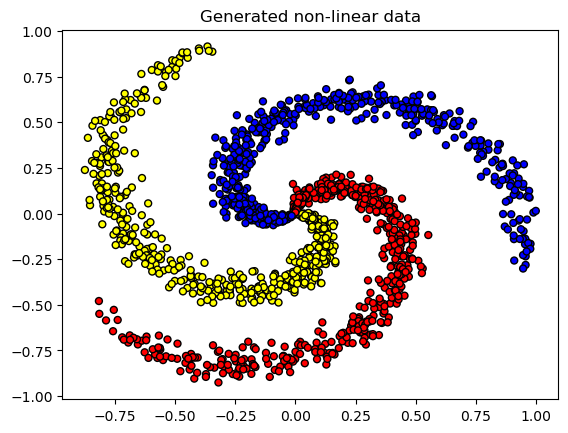

In [8]:
# Visualize data
plt.title("Generated non-linear data")
colors = {"c1": "red", "c2": "yellow", "c3": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], edgecolors="k", s=25)
plt.show()

## Split data for training and validation

In [10]:
import collections
from sklearn.model_selection import train_test_split


TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test




# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)

print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")



X_train: (1050, 2), y_train: (1050,)
X_val: (225, 2), y_val: (225,)
X_test: (225, 2), y_test: (225,)
Sample point: [-0.63919105 -0.69724176] → c1


In [12]:
from sklearn.preprocessing import LabelEncoder

# Output vectorizer
label_encoder = LabelEncoder()

# Fit on train data
label_encoder = label_encoder.fit(y_train)
classes = list(label_encoder.classes_)
print (f"classes: {classes}")


# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)
print (f"y_train[0]: {y_train[0]}")


# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")



classes: ['c1', 'c2', 'c3']
y_train[0]: c1
y_train[0]: 0
counts: [350 350 350]
weights: {0: 0.002857142857142857, 1: 0.002857142857142857, 2: 0.002857142857142857}


## Define Neural Network

In [14]:
import torch

# Set seed for reproducibility
torch.manual_seed(SEED)


from torch import nn
import torch.nn.functional as F

INPUT_DIM = X_train.shape[1] # X is 2-dimensional
HIDDEN_DIM = 100
NUM_CLASSES = len(classes) # 3 classes


class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in):
        z = self.fc1(x_in) # linear activation
        z = self.fc2(z)
        return z
    
    
# Initialize model
model = LinearModel(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)

    

ModuleNotFoundError: No module named 'torch'

## Define Metric 

In [33]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [20]:
from torch.optim import Adam

LEARNING_RATE = 1e-2
NUM_EPOCHS = 10
BATCH_SIZE = 32


# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)


# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%1==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")
        
        

Epoch: 0 | loss: 1.15, accuracy: 48.4
Epoch: 1 | loss: 1.02, accuracy: 46.9
Epoch: 2 | loss: 0.94, accuracy: 55.7
Epoch: 3 | loss: 0.89, accuracy: 63.3
Epoch: 4 | loss: 0.85, accuracy: 60.5
Epoch: 5 | loss: 0.80, accuracy: 56.3
Epoch: 6 | loss: 0.77, accuracy: 53.1
Epoch: 7 | loss: 0.76, accuracy: 54.1
Epoch: 8 | loss: 0.75, accuracy: 53.4
Epoch: 9 | loss: 0.74, accuracy: 53.1


## Visualize Results

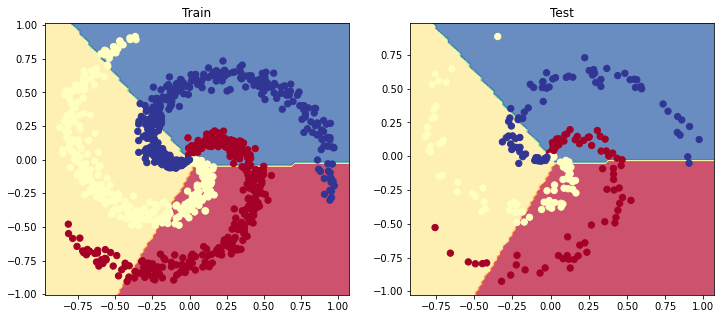

In [21]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = F.softmax(model(X_test), dim=1)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    
    
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()    
    

## Non-linear Activation Functions

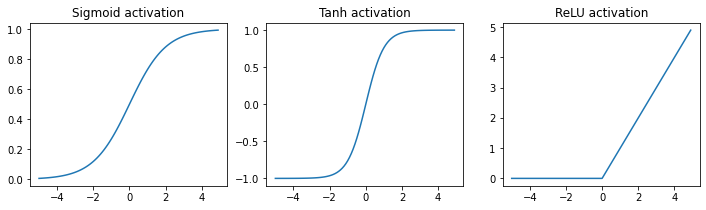

In [23]:
#  Fig size
plt.figure(figsize=(12,3))

# Data
x = torch.arange(-5., 5., 0.1)

# Sigmoid activation (constrain a value between 0 and 1.)
plt.subplot(1, 3, 1)
plt.title("Sigmoid activation")
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())

# Tanh activation (constrain a value between -1 and 1.)
plt.subplot(1, 3, 2)
y = torch.tanh(x)
plt.title("Tanh activation")
plt.plot(x.numpy(), y.numpy())

# Relu (clip the negative values to 0)
plt.subplot(1, 3, 3)
y = F.relu(x)
plt.title("ReLU activation")
plt.plot(x.numpy(), y.numpy())

# Show plots
plt.show()



## Non-linear Neural Network

In [25]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in):
        z = F.relu(self.fc1(x_in)) # ReLU activation function added!
        z = self.fc2(z)
        return z
    
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)


<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [27]:
# Training
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)


# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)


for epoch in range(NUM_EPOCHS*10):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 1.12, accuracy: 21.2
Epoch: 10 | loss: 0.75, accuracy: 55.0
Epoch: 20 | loss: 0.64, accuracy: 57.4
Epoch: 30 | loss: 0.54, accuracy: 66.2
Epoch: 40 | loss: 0.45, accuracy: 77.1
Epoch: 50 | loss: 0.37, accuracy: 83.6
Epoch: 60 | loss: 0.31, accuracy: 87.3
Epoch: 70 | loss: 0.26, accuracy: 90.5
Epoch: 80 | loss: 0.22, accuracy: 92.4
Epoch: 90 | loss: 0.19, accuracy: 94.0


### Visualize New Results

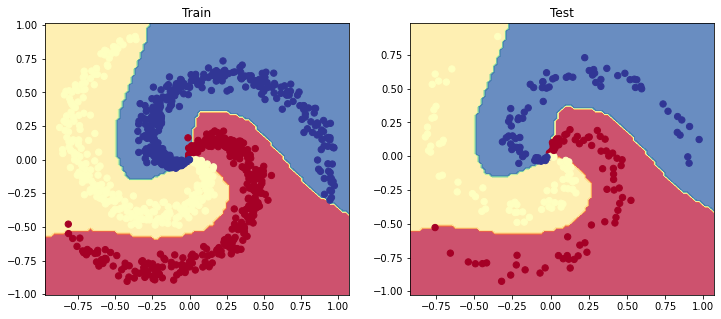

In [28]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()